In [7]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

## а

In [135]:
degrees = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
n = 100

In [136]:
sample_a = []
for i in range(len(degrees)):
    sample_a.extend([i for j in range(degrees[i])])
    
points_a = np.linspace(0, 9, 100)
f_emp = [np.sum(sample_a<elem)/n for elem in points_a]
f_acc = [x/10 for x in points_a]

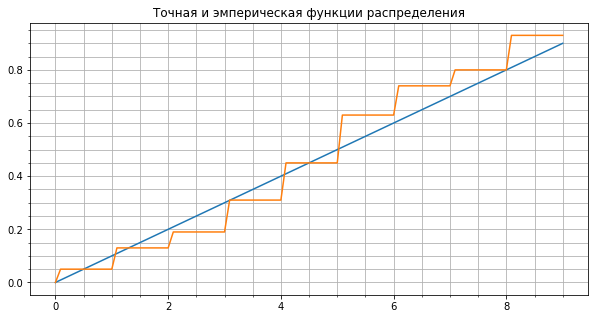

In [138]:
plt.figure(figsize=(10, 5))
plt.title("Точная и эмперическая функции распределения")
plt.plot(points_a, f_acc)
plt.plot(points_a, f_emp)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor')

In [140]:
sub = 10*max(list(map(lambda x,y: abs(x-y), f_acc, f_emp)))
print(f"Оценка дельта по критерию Колмогорова равняется {round(sub, 2)}")

Оценка дельта по критерию Колмогорова равняется 1.31


In [142]:
s = 0
for i in range(1, 5001):
    s += -2*(-1)**(i)*np.exp(-2*i*i*sub*sub)
print(f"p-value = {round(s, 3)} => нет оснований отвергать H0")

p-value = 0.065 => нет оснований отвергать H0


## b

### Хи-квадрат

In [143]:
def gauss(x, sigma, a):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - a)**2 / (2 * sigma**2) )

borders = [i/10 for i in range(5, 86, 10)]
borders.insert(0, -np.inf)
borders.append(np.inf)

sigmas = np.linspace(1, 5, 100)
aa = np.linspace(0, 7, 100)

In [144]:
#подбираем лучшие параметры нормального распределения
l_max = 0
p_best = tuple()
for sigma in sigmas:
    for a in aa:
        p = []
        for i in range(len(borders) - 1):
            p.append(integrate.quad(gauss, borders[i], borders[i+1], args = (sigma, a))[0])
        l = np.prod(list(map(lambda x, y: x**y, p, degrees)))
        if l > l_max:
            l_max = l
            p_best = (sigma, a)

In [147]:
print(f"Лучшие параметры для нормального распределения: sigma = {round(p_best[0], 2)}, a = {round(p_best[1], 2)}")

Лучшие параметры для нормального распределения: sigma = 2.7, a = 4.81


In [148]:
sigma_best = 2.7
a_best = 4.8
p_all = []
for i in range(len(borders) - 1):
    p_all.append(integrate.quad(gauss, borders[i], borders[i+1], args = (sigma_best, a_best))[0])

In [149]:
deltas = []
for i in range(10):
    deltas.append((degrees[i] - n*p_all[i])**2/(n*p_all[i]))

In [150]:
print(f"Оценка дельта с помощью критерия хи-квадрат равняется {round(np.sum(deltas), 2)}")

Оценка дельта с помощью критерия хи-квадрат равняется 9.78


### Колмогоров

In [151]:
#бутстрап
N = 50000
sample_first = []
for i in range(len(degrees)):
    sample_first.extend([i for j in range(degrees[i])])
    
deltas_kolm = []
for i in range(N):
    sample = np.random.normal(a_best, sigma_best, n)
    points = np.linspace(0, max(max(sample), 9), 100)
    f1 = [np.sum(sample<elem)/n for elem in points]
    f2 = [np.sum(sample_first<elem)/n for elem in points]
    tmp = 10*max(list(map(lambda x,y: abs(x-y), f1, f2)))
    deltas_kolm.append(tmp)

deltas_var = np.sort(deltas_kolm)
k = len(deltas_var[deltas_var<1.299999])

In [152]:
p_value = 1-((k-1)/N)
print(f"p_value = {round(p_value, 2)} => нет оснований отвергать H0")

p_value = 0.53 => нет оснований отвергать H0


## c

In [154]:
a_c = np.mean(sample_a)
sigma_c = np.std(sample_a)

In [155]:
deltas_omm = []
values = [i for i in range(10)]
N = 50000
for i in range(N):
    sample = np.random.normal(a_c, sigma_c, n)
    a_tmp = np.mean(sample)
    sigma_tmp = np.std(sample)
    p_c = []
    for i in range(len(borders) - 1):
        p_c.append(integrate.quad(gauss, borders[i], borders[i+1], args = (sigma_tmp, a_tmp))[0])
    
    num_in_intervals = [len(sample[(sample >= borders[i]) & (sample <= borders[i+1])]) for i in range(len(borders)-1)]
    deltas_omm.append(sum(((num_in_intervals[i] - n*p_c[i])**2)/(n*(p_c[i]+0.00001)) for i in range(len(p_c))))

In [158]:
deltas_var_omm = np.sort(deltas_omm)
k_omm = len(deltas_var_omm[deltas_var_omm<9.79999])

In [162]:
p_value_omm = 1-((k_omm-1)/N)
print(f"p_value = {round(p_value_omm, 2)} => нет оснований отвергать H0")

p_value = 0.21 => нет оснований отвергать H0


In [163]:
from scipy.stats import chi2
from scipy.special import gammainc, gamma

In [167]:
def cdf_chi2(x, k):
    return 3*gammainc(k/2, x/2)/gamma(k/2)

X = np.linspace(0, 30, 100)
arr7 = []
arr9 = []
for x in X:
    arr7.append(integrate.quad(chi2.pdf, 0, x, args=7)[0])
    arr9.append(integrate.quad(chi2.pdf, 0, x, args=9)[0])
    
fun = [len(deltas_var_omm[deltas_var_omm<x])/N for x in X]

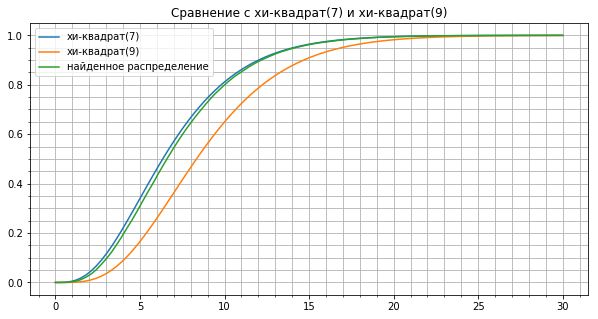

In [168]:
plt.figure(figsize=(10, 5))
plt.title("Сравнение с хи-квадрат(7) и хи-квадрат(9)")
plt.plot(X, arr7, label="хи-квадрат(7)")
plt.plot(X, arr9, label="хи-квадрат(9)")
plt.plot(X, fun, label="найденное распределение")
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor')
plt.legend()